# **PRÁCTICA 2: MODELOS CONEXIONISTAS - Algoritmo LMS y variantes. Estructuras.**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 3ª curso del Grado Ciencia de Datos

#### 1 Estructuras adaptativas: Estructura directa.   
En este apartado vamos a implementar una estructura directa que nos va a permitir analizar el LMS básico junto con sus variantes. La estructura directa viene dada por la siguiente figura, donde el sistema desconocido es un filtro FIR:


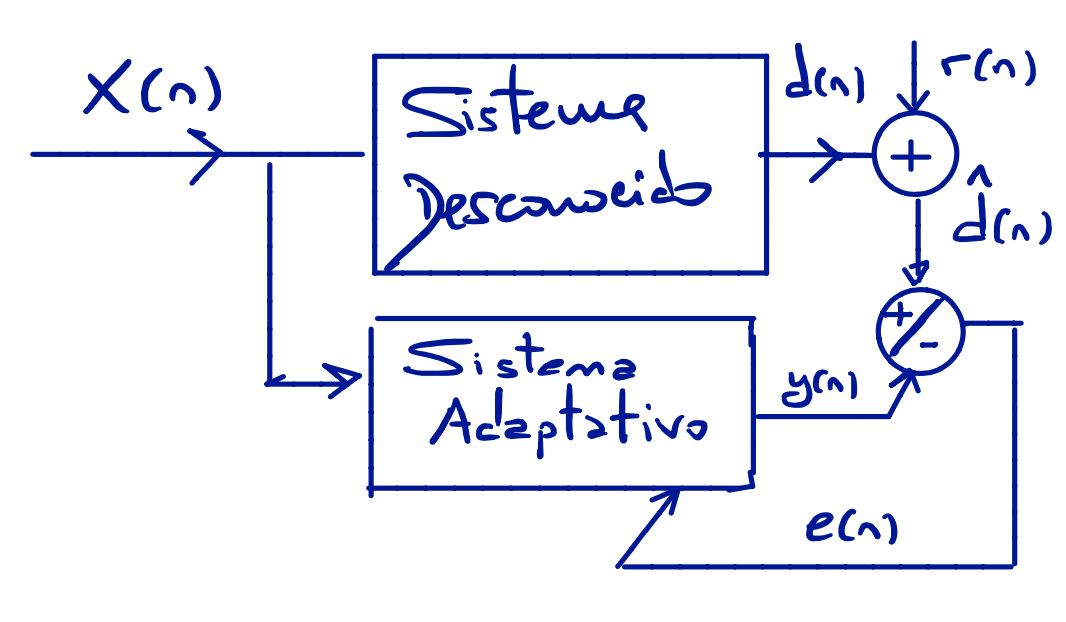


La entrada $x[n]$ será una señal gaussiana de media cero y varianza unidad, de tantas muestras como iteraciones a realizar, y $r[n]$ es ruido gaussiano que se le puede sumar a la salida del sistema desconocido (su varianza es una variable que se solicita).

**Algoritmo**

Tenemos un filtro adaptativo de respuesta impulsional $ℎ_𝑎[𝑛]$, de $𝐿_𝑎$ coeficientes, cuya señal de salida $𝑦_𝑎[𝑛]$ se calcula a partir de $𝐿_𝑎$ muestras previas de $𝑥[𝑛]$ como:   

$$𝑦_𝑎[𝑛] = ℎ_𝑎[0]⋅𝑥[𝑛] + ℎ_𝑎[1]⋅𝑥[𝑛−1] + ℎ_𝑎[2]⋅𝑥[𝑛−2] +...+ ℎ_𝑎[𝐿_𝑎−1]⋅𝑥[𝑛−𝐿_𝑎+1]$$   


Notar que x está girado (numpy.flip()) al multiplicar a los coeficientes, y que necesitamos crear $𝐿_𝑎−1$ muestras adicionales de x para empezar a predecir (además de la muestra que nos llega en 𝑛=0, en total $𝐿_𝑎$). Para la salida del filtro desconocido de longitud $𝐿_𝑑$:


$$𝑦_𝑑[𝑛] = ℎ_𝑑[0]⋅𝑥[𝑛] + ℎ_𝑑[1]⋅𝑥[𝑛−1] + ℎ_𝑑[2]⋅𝑥[𝑛−2] +...+ ℎ_𝑑[𝐿_𝑑−1]⋅𝑥[𝑛−𝐿_𝑑+1]$$


En este caso necesitamos $𝐿_𝑑−1$ muestras adicionales de x, más la que está en 𝑛 =0, para empezar a predecir.   

- A la salida del sistema desconocido se añade ruido: $𝑦′_𝑑[𝑛] = 𝑦_𝑑[𝑛] + 𝑟[𝑛]$ 

- La señal de error $𝑒[𝑛]$ se calcula como: $𝑒[𝑛] = 𝑦′_𝑑[𝑛] − 𝑦_𝑎[𝑛]$

A continuación se actualizan los coeficientes del filtro (algoritmo LMS): 


$$ℎ_𝑎[𝑘] = ℎ_𝑎[𝑘] + 𝜇 ⋅ 𝑒[𝑛] ⋅ 𝑥[𝑛−𝑘], 𝑘 = 0, 1, ..., 𝐿_𝑎−1$$

donde 𝜇 es la constante de adaptación que controla la velocidad de convergencia. El proceso completo puede repetirse varias veces y obtener varios $ℎ_𝑎$ que se pueden promediar para obtener una mejor estimación.   

Implementa dicha estructura (usando la librería numpy). El programa desarrollado debería solicitar lo siguiente:   

1. Respuesta impulsional del sistema desconocido ($h[n]$)
2. Longitud del sistema adaptativo ($L_a$). Por defecto 20.
3. Número de iteraciones N = nº de muestras de $x[n]$. Por defecto 1000.
4. Varianza del ruido r(n). Por defecto 0.01
5. Constante de adaptación. Por defecto 0.01.
6. Número de promediados. Por defecto 100.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [ ]:
def LMS(La, Ld, n_iter, var, nu, n_prome):
    """
    # Longitud del sistema adaptativo (𝐿𝑎)
    # Longitud del sistema adaptativo (𝐿d)
    # Número de iteraciones N = nº de muestras de  𝑥[𝑛] (n_iter)
    # Varianza del ruido r(n) (var)
    # Constante de adaptación. (nu)
    # Número de promediados (n_prome)
    # Sistema desconocido de prueba (self.h_d)
    """

    lista_actualizaciones = []
    lista_medias = []
    promedio = []
    lista_errores = []
    h_d = 0.1 * np.random.randn(Ld)

    for a in range (n_prome):
        salida = [] # para quedarnos con las últimas iteraciones
        h_a = np.random.randn(La)
        ruido = np.random.normal(loc = 0, scale = np.sqrt(var), size = n_iter)
        
        if La == Ld: 
            Xd  = np.random.normal(loc = 0, scale = 1, size = n_iter + max(Ld,La)-1)
            Xa  = Xd    
        else: 
            if (La > Ld):
                Xa = np.random.normal(loc = 0, scale = 1, size = n_iter + La-1)
                Xd = Xa[La-Ld:]
            else:
                Xd = np.random.normal(loc = 0, scale = 1, size = n_iter + Ld-1)
                Xa = Xd[Ld-La:]
            
        for i in range (n_iter):
            
            # Salida sistema adaptativo
            ya = np.dot(h_a, np.flip(Xa[i:La+i]))
            # Salida sistema desconocido 
            yd = np.dot(h_d, np.flip(Xd[i:Ld+i])) + ruido[i]
            # Calculamos el error
            error = (yd-ya)
            # Guardamos el error
            salida.append((error)**2)
            # Actualizar los coeficientes del filtro
            h_a = h_a + nu * error * np.flip(Xa[i:La+i])
        
        # Guardamos las actualizaciones
        lista_actualizaciones.append(h_a)
        
        promedio.append(salida)
    # Media del ha promedio, para dar una estimación más robusta de los 
    # coeficientes del filtro deconocido
    media = np.mean(lista_actualizaciones, axis= 0)
    lista_errores = np.mean(np.array(promedio),axis=0)
    
    return media, h_d, lista_errores             

In [ ]:
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)

In [ ]:
media

array([ 0.01034678,  0.03486341, -0.01532568,  0.19713657, -0.19626528,
       -0.00345873,  0.03903304,  0.06189664, -0.01075071, -0.01040872,
        0.07694124,  0.14030025,  0.04467027, -0.23775721,  0.04136297,
        0.07151701, -0.02391442, -0.03531814, -0.26612627, -0.11180977])

In [ ]:
h_d

array([ 0.01036035,  0.03517557, -0.01631578,  0.1962672 , -0.19748021,
       -0.00312101,  0.03843981,  0.06108402, -0.01054426, -0.01172146,
        0.07568184,  0.1403462 ,  0.04639062, -0.23692312,  0.04109194,
        0.07000884, -0.0240272 , -0.0350263 , -0.26700674, -0.11224118])

**Aplicación**   

La salida a mostrar en todos los casos que vienen a continuación es el $e_2(k)$, en escala lineal y semilogarítmica (semilogy).

Utiliza el siguiente sistema desconocido de prueba: h = 0.1\*np.random.randn($L_d$) donde $L_d$ es la longitud de h (por ejemplo $L_d=20$). Con este sistema determina las siguientes pruebas con las siguientes condiciones considerando la presencia de ruido y su ausencia (varía su varianza entre 0 y 1 para ver cómo impacta su presencia). Comprueba si, al final de la convergencia, el sistema adaptativo modeliza el sistema desconocido  

• **Considera que la longitud del sistema desconocido es igual, mayor o menor que la del sistema adaptativo; ¿qué ocurre?**

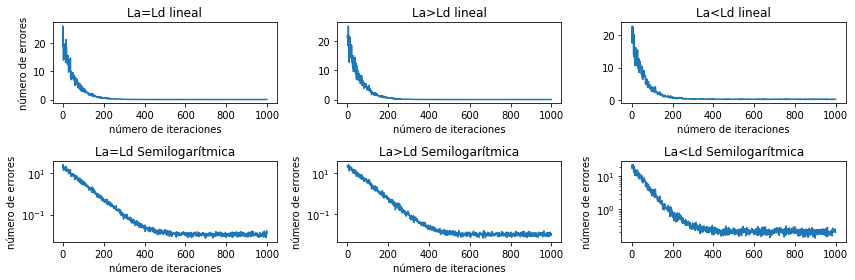

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

# Graficamos el número de errores en cada iteración (La=Ld)
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)
axes[0,0].plot(lista_errores)
axes[0,0].set_title("La=Ld lineal")
axes[0,0].set_ylabel("número de errores")
axes[0,0].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,0].semilogy(lista_errores)
axes[1,0].set_title("La=Ld Semilogarítmica")
axes[1,0].set_ylabel("número de errores")
axes[1,0].set_xlabel("número de iteraciones")

# Graficamos el número de errores en cada iteración (La>Ld)
media, h_d, lista_errores = LMS(La = 20, Ld = 10, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)
axes[0,1].plot(lista_errores)
axes[0,1].set_title("La>Ld lineal")
axes[0,1].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,1].semilogy(lista_errores)
axes[1,1].set_title("La>Ld Semilogarítmica")
axes[1,1].set_ylabel("número de errores")
axes[1,1].set_xlabel("número de iteraciones")

# Graficamos el número de errores en cada iteración (La<Ld)
media, h_d, lista_errores = LMS(La = 20, Ld = 40, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)
axes[0,2].plot(lista_errores)
axes[0,2].set_title("La<Ld lineal")
axes[0,2].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,2].semilogy(lista_errores)
axes[1,2].set_title("La<Ld Semilogarítmica")
axes[1,2].set_ylabel("número de errores")
axes[1,1].set_xlabel("número de iteraciones")

plt.tight_layout()
plt.show()

### Respuesta

Si queremos identificar un sistema desconocido h[n] de longitud Ld con un filtro adaptativo de longitud La. Se debe cmplir que La>= para obtener un resultado adecuado, descartando los coeficientes nulos de la h[n] estimada más a la derecha. 

Como podemos ver en las gráficas cuando tenemos que La=Ld, tenemos mayor número de errores. Cunado La>Ld es el caso perfecto. mientras que La<Ld nos errores no convergen de la misma manera.

• **Varía la constante de adaptación y comprueba lo que ocurre.**   

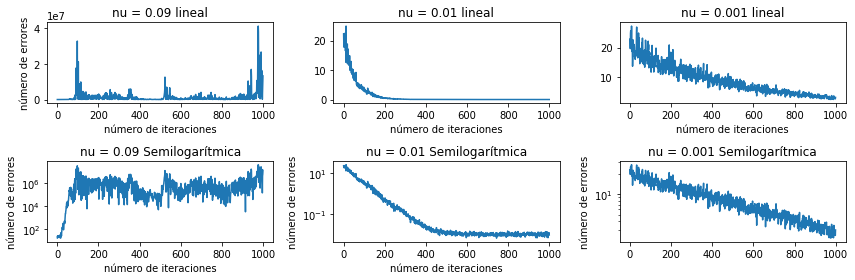

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

# Graficamos el número de errores en cada iteración (La=Ld)
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.09, n_prome = 100)
axes[0,0].plot(lista_errores)
axes[0,0].set_title("nu = 0.09 lineal")
axes[0,0].set_ylabel("número de errores")
axes[0,0].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,0].semilogy(lista_errores)
axes[1,0].set_title("nu = 0.09 Semilogarítmica")
axes[1,0].set_ylabel("número de errores")
axes[1,0].set_xlabel("número de iteraciones")

# Graficamos el número de errores en cada iteración (La>Ld)
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)
axes[0,1].plot(lista_errores)
axes[0,1].set_title("nu = 0.01 lineal")
axes[0,1].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,1].semilogy(lista_errores)
axes[1,1].set_title("nu = 0.01 Semilogarítmica")
axes[1,1].set_ylabel("número de errores")
axes[1,1].set_xlabel("número de iteraciones")

# Graficamos el número de errores en cada iteración (La<Ld)
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.001, n_prome = 100)
axes[0,2].plot(lista_errores)
axes[0,2].set_title("nu = 0.001 lineal")
axes[0,2].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,2].semilogy(lista_errores)
axes[1,2].set_title("nu = 0.001 Semilogarítmica")
axes[1,2].set_ylabel("número de errores")
axes[1,1].set_xlabel("número de iteraciones")

plt.tight_layout()
plt.show()

### Respuesta

Como podemos ver la constatne de adaptación es un parámetro importante para conseguir un funcionamiento óptimo del sistema.

- Si la constante de adaptación toma valores altos, como podemos ver en la gráfica, los valores no logran una buena aproximación de los coeficientes del filtro desconocido. Estos tienen mayor número de error. 

- Si la constante de adaptación toma valores menores, como podemos ver en la gráfica, los valores logran una aproximación más exacta a los coeficientes del filtro desconocido pero requieren mayor número de iteraciones.

• **Implementa las variantes con signo; ¿cómo es su convergencia en relación al LMS básico?**  

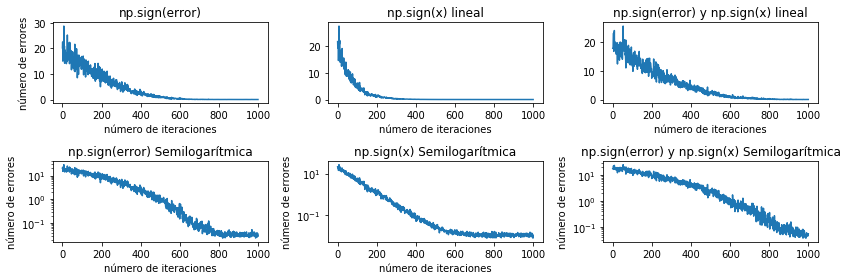

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))
def LMS(La, Ld, n_iter, var, nu, n_prome):
    lista_actualizaciones = []
    lista_medias = []
    promedio = []
    lista_errores = []
    h_d = 0.1 * np.random.randn(Ld)
    for a in range (n_prome):
        salida = [] # para quedarnos con las últimas iteraciones
        h_a = np.random.randn(La)
        ruido = np.random.normal(loc = 0, scale = np.sqrt(var), size = n_iter)       
        if La == Ld: 
            Xd  = np.random.normal(loc = 0, scale = 1, size = n_iter + max(Ld,La)-1)
            Xa  = Xd    
        else: 
            if (La > Ld):
                Xa = np.random.normal(loc = 0, scale = 1, size = n_iter + La-1)
                Xd = Xa[La-Ld:]
            else:
                Xd = np.random.normal(loc = 0, scale = 1, size = n_iter + Ld-1)
                Xa = Xd[Ld-La:]           
        for i in range (n_iter):           
            # Salida sistema adaptativo
            ya = np.dot(h_a, np.flip(Xa[i:La+i]))
            # Salida sistema desconocido 
            yd = np.dot(h_d, np.flip(Xd[i:Ld+i])) + ruido[i]
            # Calculamos el error
            error = (yd-ya)
            # Guardamos el error
            salida.append((error)**2)
            # Actualizar los coeficientes del filtro
            h_a = h_a + nu * np.sign(error) * np.flip(Xa[i:La+i])
        # Guardamos las actualizaciones
        lista_actualizaciones.append(h_a)
        promedio.append(salida)
    # Media del ha promedio, para dar una estimación más robusta de los 
    # coeficientes del filtro deconocido
    media = np.mean(lista_actualizaciones, axis= 0)
    lista_errores = np.mean(np.array(promedio),axis=0)
    return media, h_d, lista_errores    
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)
axes[0,0].plot(lista_errores)
axes[0,0].set_title("np.sign(error)")
axes[0,0].set_ylabel("número de errores")
axes[0,0].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,0].semilogy(lista_errores)
axes[1,0].set_title("np.sign(error) Semilogarítmica")
axes[1,0].set_ylabel("número de errores")
axes[1,0].set_xlabel("número de iteraciones")

# Graficamos el número de errores en cada iteración (La>Ld)
def LMS(La, Ld, n_iter, var, nu, n_prome):
    lista_actualizaciones = []
    lista_medias = []
    promedio = []
    lista_errores = []
    h_d = 0.1 * np.random.randn(Ld)
    for a in range (n_prome):
        salida = [] # para quedarnos con las últimas iteraciones
        h_a = np.random.randn(La)
        ruido = np.random.normal(loc = 0, scale = np.sqrt(var), size = n_iter)       
        if La == Ld: 
            Xd  = np.random.normal(loc = 0, scale = 1, size = n_iter + max(Ld,La)-1)
            Xa  = Xd    
        else: 
            if (La > Ld):
                Xa = np.random.normal(loc = 0, scale = 1, size = n_iter + La-1)
                Xd = Xa[La-Ld:]
            else:
                Xd = np.random.normal(loc = 0, scale = 1, size = n_iter + Ld-1)
                Xa = Xd[Ld-La:]           
        for i in range (n_iter):           
            # Salida sistema adaptativo
            ya = np.dot(h_a, np.flip(Xa[i:La+i]))
            # Salida sistema desconocido 
            yd = np.dot(h_d, np.flip(Xd[i:Ld+i])) + ruido[i]
            # Calculamos el error
            error = (yd-ya)
            # Guardamos el error
            salida.append((error)**2)
            # Actualizar los coeficientes del filtro
            h_a = h_a + nu * error * np.sign(np.flip(Xa[i:La+i]))
        # Guardamos las actualizaciones
        lista_actualizaciones.append(h_a)
        promedio.append(salida)
    # Media del ha promedio, para dar una estimación más robusta de los 
    # coeficientes del filtro deconocido
    media = np.mean(lista_actualizaciones, axis= 0)
    lista_errores = np.mean(np.array(promedio),axis=0)
    return media, h_d, lista_errores  
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)
axes[0,1].plot(lista_errores)
axes[0,1].set_title("np.sign(x) lineal")
axes[0,1].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,1].semilogy(lista_errores)
axes[1,1].set_title("np.sign(x) Semilogarítmica")
axes[1,1].set_ylabel("número de errores")
axes[1,1].set_xlabel("número de iteraciones")

def LMS(La, Ld, n_iter, var, nu, n_prome):
    lista_actualizaciones = []
    lista_medias = []
    promedio = []
    lista_errores = []
    h_d = 0.1 * np.random.randn(Ld)
    for a in range (n_prome):
        salida = [] # para quedarnos con las últimas iteraciones
        h_a = np.random.randn(La)
        ruido = np.random.normal(loc = 0, scale = np.sqrt(var), size = n_iter)       
        if La == Ld: 
            Xd  = np.random.normal(loc = 0, scale = 1, size = n_iter + max(Ld,La)-1)
            Xa  = Xd    
        else: 
            if (La > Ld):
                Xa = np.random.normal(loc = 0, scale = 1, size = n_iter + La-1)
                Xd = Xa[La-Ld:]
            else:
                Xd = np.random.normal(loc = 0, scale = 1, size = n_iter + Ld-1)
                Xa = Xd[Ld-La:]           
        for i in range (n_iter):           
            # Salida sistema adaptativo
            ya = np.dot(h_a, np.flip(Xa[i:La+i]))
            # Salida sistema desconocido 
            yd = np.dot(h_d, np.flip(Xd[i:Ld+i])) + ruido[i]
            # Calculamos el error
            error = (yd-ya)
            # Guardamos el error
            salida.append((error)**2)
            # Actualizar los coeficientes del filtro
            h_a = h_a + nu * np.sign(error) * np.sign(np.flip(Xa[i:La+i]))
        # Guardamos las actualizaciones
        lista_actualizaciones.append(h_a)
        promedio.append(salida)
    # Media del ha promedio, para dar una estimación más robusta de los 
    # coeficientes del filtro deconocido
    media = np.mean(lista_actualizaciones, axis= 0)
    lista_errores = np.mean(np.array(promedio),axis=0)
    return media, h_d, lista_errores 
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)
axes[0,2].plot(lista_errores)
axes[0,2].set_title("np.sign(error) y np.sign(x) lineal")
axes[0,2].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,2].semilogy(lista_errores)
axes[1,2].set_title("np.sign(error) y np.sign(x) Semilogarítmica")
axes[1,2].set_ylabel("número de errores")
axes[1,1].set_xlabel("número de iteraciones")

plt.tight_layout()
plt.show()

### Respuesta

Como podemos ver, las variantes con signo de LMS, necesitan más iteraciones para alcanzar errores similares a los de LMS estándar en estado estacionario para una misma constante de adaptación. Sign(x) lineal es el que menos iteraciones necesita, mientras que sign(error) y sign(x) lineal junto con la semilogarítmica son las que más iteraciones necesitan.

• **Implementa la variante normalizada y compárala con el LMS, básico; ¿qué diferencias observas?**

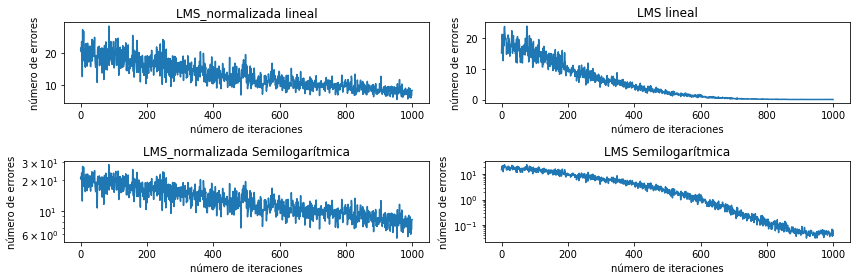

In [ ]:
# Graficamos el número de errores en cada iteración (La<Ld)
def LMS_normalizada(La, Ld, n_iter, var, nu, n_prome, eps):
    lista_actualizaciones = []
    lista_medias = []
    promedio = []
    lista_errores = []
    h_d = 0.1 * np.random.randn(Ld)
    for a in range (n_prome):
        salida = [] # para quedarnos con las últimas iteraciones
        h_a = np.random.randn(La)
        ruido = np.random.normal(loc = 0, scale = np.sqrt(var), size = n_iter)       
        if La == Ld: 
            Xd  = np.random.normal(loc = 0, scale = 1, size = n_iter + max(Ld,La)-1)
            Xa  = Xd    
        else: 
            if (La > Ld):
                Xa = np.random.normal(loc = 0, scale = 1, size = n_iter + La-1)
                Xd = Xa[La-Ld:]
            else:
                Xd = np.random.normal(loc = 0, scale = 1, size = n_iter + Ld-1)
                Xa = Xd[Ld-La:]           

        for i in range (n_iter):           
            # Salida sistema adaptativo
            ya = np.dot(h_a, np.flip(Xa[i:La+i]))
            # Salida sistema desconocido 
            yd = np.dot(h_d, np.flip(Xd[i:Ld+i])) + ruido[i]
            # Calculamos el error
            error = (yd-ya)
            # Guardamos el error
            salida.append((error)**2)
            # Actualizar los coeficientes del filtro
            Xa_ = np.flip(Xa[i:La + i])
            nu2 = nu / (np.linalg.norm(Xa_)**2 + eps)
            h_a = h_a + nu2 * error * Xa_
        # Guardamos las actualizaciones
        lista_actualizaciones.append(h_a)
        promedio.append(salida)
    # Media del ha promedio, para dar una estimación más robusta de los 
    # coeficientes del filtro deconocido
    media = np.mean(lista_actualizaciones, axis= 0)
    lista_errores = np.mean(np.array(promedio),axis=0)
    return media, h_d, lista_errores
fig, axes = plt.subplots(2, 2, figsize=(12, 4))
# Graficamos el número de errores en cada iteración
media, h_d, lista_errores = LMS_normalizada(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100, eps = 10e-5)
axes[0,0].plot(lista_errores)
axes[0,0].set_title("LMS_normalizada lineal")
axes[0,0].set_ylabel("número de errores")
axes[0,0].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,0].semilogy(lista_errores)
axes[1,0].set_title("LMS_normalizada Semilogarítmica")
axes[1,0].set_ylabel("número de errores")
axes[1,0].set_xlabel("número de iteraciones")

# Graficamos el número de errores en cada iteración
media, h_d, lista_errores = LMS(La = 20, Ld = 20, n_iter = 1000, var = 0.01, nu = 0.01, n_prome = 100)
axes[0,1].plot(lista_errores)
axes[0,1].set_title("LMS lineal")
axes[0,1].set_ylabel("número de errores")
axes[0,1].set_xlabel("número de iteraciones")
# Escala semilogaritmica
axes[1,1].semilogy(lista_errores)
axes[1,1].set_title("LMS Semilogarítmica")
axes[1,1].set_ylabel("número de errores")
axes[1,1].set_xlabel("número de iteraciones")


plt.tight_layout()
plt.show()

### Respuesta

Como podemos ver, el LMS normalizado permite la convergencia en menos iteraciones frente a LMS básico logrando errores similares en estado estacionario.

#### 2 Cancelador activo de ruido. Aplicación al ECG fetal.   
La estructura de un cancelador activo de ruido viene dada por el siguiente esquema:   

![image.png](attachment:image.png)

Un ejemplo clásico de esta estructura es la obtención del electrocardiograma fetal teniendo como principal interferencia el electrocardiograma materno. El problema es que estas dos señales tienen un contenido espectral similar por lo que intentar un filtrado selectivo en frecuencia supone distorsionar la señal de interés; en este caso el electrocardiograma fetal. Como solución se plantea un cancelador activo de ruido donde la señal deseada es la señal que se obtiene del abdomen de la madre (tiene componentes maternos y fetales) y la señal de entrada al filtro adaptativo es la señal que se obtiene del sensor que se le coloca en el pecho a la madre; este sensor tomaría, en principio, solo componente materna. El sistema adaptativo modelizaría la componente materna que se encuentra en el sensor que se coloca en el abdomen de la madre de tal forma que la señal de error resultante sólo tendría componente fetal. La siguiente figura es un esquema del dispositivo experimental planteado.

El fichero fetal_lms.mat contiene dos señales; la torácica y la abdominal; la torácica será la entrada al filtro adaptativo y la abdominal es la que contiene las dos componentes (fetal y materna interferente). Determina:   

![image.png](attachment:image.png)

a) La visualización de ambas señales.   

In [ ]:
annots = loadmat('fetal_lms.mat')
# Entrada al filtro adaptativo
torac = annots['torac']
# Contiene las dos componentes (fetal y materna interferente)
abdom = annots['abdom']

Text(0.5, 1.0, 'Señal abdominal')

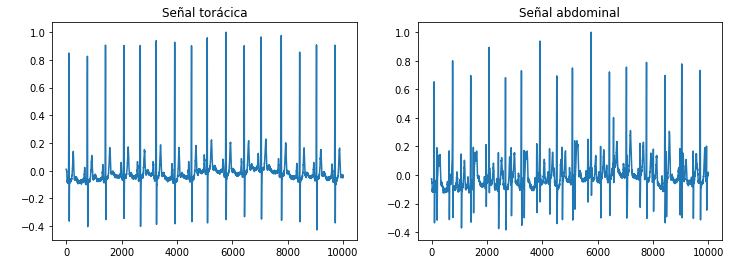

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# TORAC annots['torac']
Xa = torac[0]
# Graficamos la primera señal
axes[0].plot(Xa)
axes[0].set_title(" ")
axes[0].set_ylabel(" ")
axes[0].set_title("Señal torácica")

# ABDOMINAL annots['abdom']
Xb = abdom[0]
# Graficamos el número de errores en cada iteración
axes[1].plot(Xb)
axes[1].set_title(" ")
axes[1].set_ylabel(" ")
axes[1].set_title("Señal abdominal")

b) Implementa el algoritmo LMS en esta aplicación (puedes usar el código del punto anterior cambiando las señales de entrada al filtro y la señal deseada); varía la longitud del filtro y la constante de adaptación.   

In [ ]:
def LMS(Xa, La, Ld, n_iter, var, nu, n_prome):
    # lista_actualizaciones = []
    # lista_medias = []
    X_n = np.random.normal(loc =0, scale= 1, size = La)
    X_n = np.append(X_n, Xa)
    output = []
    promedio =[]
    for a in range (n_prome):
        # lista_errores = []
        salida = []
        h_a = np.random.randn(La)
        ruido = np.random.normal(loc = 0, scale = np.sqrt(var), size = n_iter)
        
        # if La == Ld:
            #Xd  = np.random.normal(loc = 0, scale = 1, size = n_iter + max(Ld,La)-1)
            #Xa  = Xd
        #else:
            #if (La > Ld):
                #Xa = np.random.normal(loc = 0, scale = 1, size = n_iter + La-1)
                #Xd = Xa[La-Ld:]
            #else:
                #Xd = np.random.normal(loc = 0, scale = 1, size = n_iter + Ld-1)
                #Xa = Xd[Ld-La:]    
        
        for i in range (n_iter):
            
            # Salida sistema adaptativo
            ya = np.dot(h_a, np.flip(X_n[i:La+i])) + ruido[i]
            # Salida sistema desconocido 
            # yd = np.dot(h_d, np.flip(Xd[i:Ld+i])) 
            # Calculamos el error
            # error = (abdominal-ya)
            # Guardamos el error
            # lista_errores.append((error)**2)
            # Actualizar los coeficientes del filtro
            # h_a = h_a + nu * error * np.flip(Xa[i:La+i])
            # Guardamos las actualizaciones
            # lista_actualizaciones.append(h_a)
            salida.append(ya)
        promedio.append(salida)
    output = np.mean(np.array(salida),axis = 0)
        # Media del ha promedio, para dar una estimación más robusta de los 
        # coeficientes del filtro deconocido
        # media = np.mean(lista_actualizaciones, axis= 0)
    
    return output    

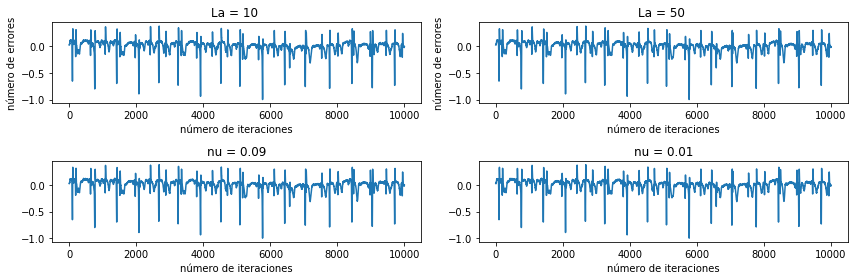

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 4))

# Longitud del filtro 
output = LMS(Xa = Xa, La = 10, Ld = 20, n_iter = 10000, var = 0.01, nu = 0.01, n_prome = 100)

fetal = Xa* output - Xb
axes[0,0].plot(fetal)
axes[0,0].set_title("La = 10 ")
axes[0,0].set_ylabel("número de errores")
axes[0,0].set_xlabel("número de iteraciones")
output = LMS(Xa = Xa, La = 50, Ld = 20, n_iter = 10000, var = 0.01, nu = 0.01, n_prome = 100)
fetal = Xa* output - Xb
axes[0,1].plot(fetal)
axes[0,1].set_title("La = 50 ")
axes[0,1].set_ylabel("número de errores")
axes[0,1].set_xlabel("número de iteraciones")

# La constante de adaptación
output = LMS(Xa = Xa, La = 20, Ld = 20, n_iter = 10000, var = 0.01, nu = 0.09, n_prome = 100)
fetal = Xa* output - Xb
axes[1,0].plot(fetal)
axes[1,0].set_title("nu = 0.09")
axes[1,0].set_xlabel("número de iteraciones")

output = LMS(Xa = Xa, La = 20, Ld = 20, n_iter = 10000, var = 0.01, nu = 0.01, n_prome = 100)
fetal = Xa* output - Xb
axes[1,1].plot(fetal)
axes[1,1].set_title("nu = 0.01")
axes[1,1].set_xlabel("número de iteraciones")

plt.tight_layout()
plt.show()

### Respuesta

Vemos que cuando La toma valores bajos, la señal fetal se diferencia con dificultad, mientras que cuando le damos valores más altos tiene picos diferenciados que toman valores cercanos a 1. En cuando a la constante nu, si toma valores altos, la señal fetal se dispara a valores positivos (en este caso cercanos a 3), y si toma valores bajos, la señal es negativa (en este caso cercanos a -3).

c) Superpón las gráficas de la señal torácica, la abdominal y la fetal estimada, que corresponde al error $e[n]$. Ten cuidado de alinear las gráficas en el instante temporal correcto ¿Qué ocurre con el complejo QRS (los picos de mayor amplitud) de la madre en la señal de salida? Haz zoom sobre algún periodo para apreciar mejor el resultado.

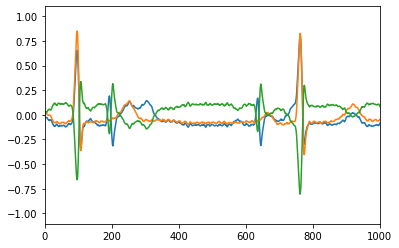

In [ ]:
output = LMS(Xa = Xa, La = 20, Ld = 20, n_iter = 10000, var = 0.01, nu = 0.01, n_prome = 100)
fetal = Xa * output - Xb

plt.plot(abdom[0])
plt.plot(torac[0])
plt.plot(fetal)
plt.xlim(0,1000)
plt.show()

### Respuesta

Lo que ocurre es que los picos de la señal de la madre se suavizan, y los picos de la señal del feto se exageran. Esto hace que podamos diferenciar abmas señales gracias al filtro.